In [38]:
!nvidia-smi

Sat May 21 14:21:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   29C    P0    44W / 163W |  20565MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   

In [2]:

import os
os.environ['CUDA_VISIBLE_DEVICES']=''


# In[3]:


import time
import sys
import os
import random
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, utils
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
from matplotlib import pyplot as plt
from collections import OrderedDict

SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
import pandas as pd

In [4]:
path_dataset = os.path.join('..','dataset','thai2rom')
test_filepaths = os.path.join(path_dataset,'test.tsv')
test_df = pd.read_csv(test_filepaths,sep="\t")

In [5]:
def load_data(data_path):
    input_texts = [str(i) for i in list(data_path['word'])]
    target_texts = [str(i) for i in list(data_path['roman'])]
    return input_texts, target_texts

In [6]:
test_input_texts, test_target_texts = load_data(test_df)

In [7]:
# Define special characters
UNK_token = '<UNK>'
PAD_token = '<PAD>'
START_token = '<start>'
END_token = '<end>'
MAX_LENGTH = 60

class Language:
    def __init__(self, name, is_input=False):
        self.name = name
        self.characters = set()
        self.n_chars = 0
        self.char2index = {}
        self.index2char = {}

        if is_input == True:
            self.index2char = { 0: PAD_token, 1: UNK_token, 2: START_token, 3: END_token }
            self.char2index = { ch:i for i, ch in self.index2char.items() } #reverse dictionary
            self.n_chars = 4
        else:
            self.index2char = { 0: PAD_token, 1: START_token, 2: END_token }
            self.char2index = { ch:i for i, ch in self.index2char.items() } #reverse dictionary
            self.n_chars = 3

    def addText(self, text):
        for character in text:
            self.addCharacter(character)
    
    def addCharacter(self, character):
        if character not in self.char2index.keys():
            self.char2index[character] = self.n_chars
            self.index2char[self.n_chars] = character
            self.n_chars += 1
            
            
def indexesFromText(lang, text):
    """returns indexes for all character given the text in the specified language"""
    return [lang.char2index[char] for char in text]

def tensorFromText(lang, text):
    """construct a tensor given the text in the specified language"""
    indexes = indexesFromText(lang, text)
    indexes.append(lang.char2index[END_token])
    
    no_padded_seq_length = len(indexes) # Number of characters in the text (including <END> token)
    # Add padding token to make all tensors in the same length
    for i in range(len(indexes), MAX_LENGTH): # padding
        indexes.append(lang.char2index[PAD_token])
        
    return torch.tensor(indexes, dtype=torch.long), no_padded_seq_length

def filterPair(p1, p2):
    """filter for the pair the both texts has length less than `MAX_LENGTH`"""
    return len(p1) < MAX_LENGTH and len(p2) < MAX_LENGTH

def tensorsFromPair(pair, lang1, lang2):
    """construct two tensors from a pair of source and target text specified by source and target language"""
    input_tensor, input_length = tensorFromText(lang1, pair[0])
    target_tensor, target_length = tensorFromText(lang2, pair[1])
    return input_tensor, target_tensor, input_length, target_length



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        input_text, target_text, lang_th, lang_th_romanized = sample['input_text'], sample['target_text'],                                                               sample['lang_th'], sample['lang_th_romanized']

        input_tensor, target_tensor, input_length, target_length = tensorsFromPair([input_text, target_text], 
                                                                                   lang_th, 
                                                                                   lang_th_romanized)
        
        return {
                'input_text': input_text,
                'target_text': target_text,
                'input_length': input_length,
                'target_length': target_length,
                'input_tensor': input_tensor,
                'target_tensor': target_tensor
               }
    
    
class ThaiRomanizationDataset(Dataset):
    """Thai Romanization Dataset class"""
    def __init__(self, 
                 data_path, 
                 transform=transforms.Compose([ ToTensor() ])):

        input_texts, target_texts = load_data(data_path)
        
        self.input_texts = input_texts
        self.target_texts = target_texts
        self.transform = transform
        self.lang_th = None
        self.lang_th_romanized = None
        self.counter = Counter()
        self.pairs = []
        self.prepareData()

    def prepareData(self):
        self.lang_th = Language('th', is_input=True)
        self.lang_th_romanized = Language('th_romanized', is_input=False)
        for i in range(len(self.input_texts)):
            
            input_text = str(self.input_texts[i])
            target_text = str(self.target_texts[i])
            
            # Count the number of input and target sequences with length `x`
            self.counter.update({ 
                                  'len_input_{}'.format(len(input_text)): 1, 
                                  'len_target_{}'.format(len(target_text)): 1 
                                })
            
            if filterPair(input_text, target_text):
                self.pairs.append((input_text, target_text))
                self.lang_th.addText(input_text)
                self.lang_th_romanized.addText(target_text)    

    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        
        sample = dict()
        sample['input_text'] = self.pairs[idx][0]
        sample['target_text'] = self.pairs[idx][1]
        
        sample['lang_th'] = self.lang_th
        sample['lang_th_romanized'] = self.lang_th_romanized

        if self.transform:
            sample = self.transform(sample)

        return sample

In [8]:
class Encoder(nn.Module):
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, dropout=0.5):
        """Constructor"""
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.character_embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, 
                            hidden_size=hidden_size // 2, 
                            bidirectional=True,
                            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, sequences, sequences_lengths):
        batch_size = sequences.size(0)
        self.hidden = self.init_hidden(batch_size) # batch_size

        # sequences :(batch_size, sequence_length=MAX_LENGTH)
        # sequences_lengths: (batch_size)  # an 1-D indicating length of each sequence (excluded <PAD> token) in `seq`
        
        # 1. Firstly we sort `sequences_lengths` according to theirs values and keep list of indexes to perform sorting
        sequences_lengths = np.sort(sequences_lengths)[::-1] # sort in ascending order and reverse it
        index_sorted = np.argsort(-sequences_lengths) # use negation in sort in descending order
        index_unsort = np.argsort(index_sorted) # to unsorted sequence
        
        
        # 2. Then, we change position of sequence in `sequences` according to `index_sorted`
        index_sorted = torch.from_numpy(index_sorted)
        sequences = sequences.index_select(0, index_sorted)
        
        # 3. Feed to Embedding Layer
        
        sequences = self.character_embedding(sequences)
        sequences = self.dropout(sequences)
        
#         print('sequences',sequences.size(), sequences)
            
        # 3. Use function: pack_padded_sequence to let LSTM packed input with same length at time step T together
        
        # Quick fix: Use seq_len.copy(), instead of seq_len to fix `Torch.from_numpy not support negative strides`
        # ndarray.copy() will alocate new memory for numpy array which make it normal, I mean the stride is not negative any more.

        sequences_packed = nn.utils.rnn.pack_padded_sequence(sequences,
                                                             sequences_lengths.copy(),
                                                             batch_first=True)
#         print('sequences_packed', sequences_packed)

        # 4. Feed to LSTM
        sequences_output, self.hidden = self.lstm(sequences_packed, self.hidden)
        
        # 5. Unpack
        sequences_output, _ = nn.utils.rnn.pad_packed_sequence(sequences_output, batch_first=True)

        # 6. Un-sort by length
        index_unsort = torch.from_numpy(index_unsort)
        sequences_output = sequences_output.index_select(0, Variable(index_unsort))

#         print('hidden shape', self.hidden[0].shape, self.hidden[0], self.hidden[1].shape, self.hidden[1])
        return sequences_output, self.hidden
    
    def init_hidden(self, batch_size):
        h_0 = torch.zeros([2, batch_size, self.hidden_size // 2], requires_grad=True)
        c_0 = torch.zeros([2, batch_size, self.hidden_size // 2], requires_grad=True)
        
        return (h_0, c_0)

In [9]:

class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()

        self.method = method
        self.hidden_size = hidden_size

        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: B x 1 x h ; 
        # encoder_outputs: B x S x h

        # Calculate energies for each encoder output
        if self.method == 'dot':
            attn_energies = torch.bmm(encoder_outputs, hidden.transpose(1, 2)).squeeze(2)  # B x S
        elif self.method == 'general':
            attn_energies = self.attn(encoder_outputs.view(-1, encoder_outputs.size(-1)))  # (B * S) x h
            attn_energies = torch.bmm(attn_energies.view(*encoder_outputs.size()),
                                      hidden.transpose(1, 2)).squeeze(2)  # B x S
        elif self.method == 'concat':
            attn_energies = self.attn(
                torch.cat((hidden.expand(*encoder_outputs.size()), encoder_outputs), 2))  # B x S x h
            attn_energies = torch.bmm(attn_energies,
                                      self.other.unsqueeze(0).expand(*hidden.size()).transpose(1, 2)).squeeze(2)

        attn_energies = attn_energies.masked_fill(mask == 0, -1e10)

        # Normalize energies to weights in range 0 to 1
        return F.softmax(attn_energies, 1)

class AttentionDecoder(nn.Module): 
    
    def __init__(self, vocabulary_size, embedding_size, hidden_size, dropout=0.5):
        """Constructor"""
        super(AttentionDecoder, self).__init__()
        self.vocabulary_size = vocabulary_size
        self.hidden_size = hidden_size
        self.character_embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size + self.hidden_size,
                            hidden_size=hidden_size,
                            bidirectional=False,
                            batch_first=True)
        
        self.attn = Attn(method="general", hidden_size=self.hidden_size)
        self.linear = nn.Linear(hidden_size * 2, vocabulary_size)
        
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, input, last_hidden, last_context, encoder_outputs, mask):
        """"Defines the forward computation of the decoder"""
        # input: (B, 1) ,
        # last_hidden: (num_layers * num_directions, B, hidden_dim)
        # last_context: (B, 1, hidden_dim)
        # encoder_outputs: (B, S, hidden_dim)
        
        embedded = self.character_embedding(input)
        embedded = self.dropout(embedded)
        
        # embedded: (batch_size, emb_dim)
        rnn_input = torch.cat((embedded, last_context), 2)

        output, hidden = self.lstm(rnn_input, last_hidden)        
        attn_weights = self.attn(output, encoder_outputs, mask)  # B x S
    
        #  context = (B, 1, S) x (B, S, hidden_dim)
        #  context = (B, 1, hidden_dim)
        context = attn_weights.unsqueeze(1).bmm(encoder_outputs)  
        
        output = torch.cat((context.squeeze(1), output.squeeze(1)), 1)
        output = self.linear(output)
        
        return output, hidden, context, attn_weights

In [10]:
class Seq2Seq(nn.Module): 

    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = 0

        assert encoder.hidden_size == decoder.hidden_size
    
    def create_mask(self, source_seq):
        mask = (source_seq != self.pad_idx)
        return mask
        
  
    def forward(self, source_seq, source_seq_len, target_seq, teacher_forcing_ratio = 0.5):
        """
            Parameters:
                - source_seq: (batch_size x MAX_LENGTH) 
                - source_seq_len: (batch_size x 1)
                - target_seq: (batch_size x MAX_LENGTH)

            Returns
        """
        batch_size = source_seq.size(0)
        start_token = char_to_ix["<start>"]
        end_token = char_to_ix["<end>"]
        max_len = MAX_LENGTH
        target_vocab_size = self.decoder.vocabulary_size

        # init a tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, target_vocab_size)
        
        if target_seq is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
        else:
            inference = False

    
        # feed mini-batch source sequences into the `Encoder`
        encoder_outputs, encoder_hidden = self.encoder(source_seq, source_seq_len)

        # create a Tensor of first input for the decoder
        decoder_input = torch.tensor([[start_token] * batch_size]).view(batch_size, 1)
        
        # Initiate decoder output as the last state encoder's hidden state
        decoder_hidden_0 = torch.cat([encoder_hidden[0][0], encoder_hidden[0][1]], dim=1).unsqueeze(dim=0)
        decoder_hidden_1 = torch.cat([encoder_hidden[1][0], encoder_hidden[1][1]], dim=1).unsqueeze(dim=0)
        decoder_hidden = (decoder_hidden_0, decoder_hidden_1) # (hidden state, cell state)

        # define a context vector
        decoder_context = Variable(torch.zeros(encoder_outputs.size(0), encoder_outputs.size(2))).unsqueeze(1)
        
        max_source_len = encoder_outputs.size(1)
        mask = self.create_mask(source_seq[:, 0:max_source_len])
            
       
        for di in range(max_len):
            decoder_output, decoder_hidden, decoder_context, attn_weights = self.decoder(decoder_input,
                                                                                    decoder_hidden,
                                                                                    decoder_context,
                                                                                    encoder_outputs,
                                                                                    mask)
            # decoder_output: (batch_size, target_vocab_size)

            topv, topi = decoder_output.topk(1)
            outputs[di] = decoder_output
    
            teacher_force = random.random() < teacher_forcing_ratio


            decoder_input = target_seq[:, di].reshape(batch_size, 1) if teacher_force else topi.detach() 

            if inference and decoder_input == end_token:
                return outputs[:di]
        return outputs

In [11]:
def inference(model, text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char):
    input_seq =  [ch for ch in text] +  ['<end>']
    numericalized = [char_2_ix[ch] for ch in input_seq] 
    
#     print('input ',numericalized)
    sentence_length = [len(numericalized)]

    tensor = torch.LongTensor(numericalized).view(1, -1) 
    
#     print(tensor)
    translation_tensor_logits = model(tensor, sentence_length, None, 0) 
#     print(translation_tensor_logits)
    if translation_tensor_logits.size(0) == 0:
        translation_indices = [0]
        translation = ['<pad>']
    else:
        translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1).cpu().numpy()
        translation_indices = [t for t in translation_tensor]
        translation = [ix_to_target_char[t] for t in translation_tensor]
    return ''.join(translation), translation_indices

In [12]:
def load_model(model_path):
    
    data = torch.load(model_path)
    
    INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, ENC_DROPOUT = data['encoder_params']
    OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, DEC_DROPOUT = data['decoder_params']

    
    encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM)
    decoder = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM)

    model = Seq2Seq(encoder, decoder)
    
    model.load_state_dict(data['model_state_dict'])
    
    
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer.load_state_dict(data['optimizer_state_dict'])
    criterion = nn.CrossEntropyLoss(ignore_index = 0)

    char_to_ix = data['char_to_ix']
    ix_to_char = data['ix_to_char'] 
    target_char_to_ix = data['target_char_to_ix']
    ix_to_target_char = data['ix_to_target_char']
    
    
    return {
        'model': model,
        'optmizer': optimizer,
        'char_to_ix': char_to_ix,
        'ix_to_char' : ix_to_char,
        'target_char_to_ix': target_char_to_ix,
        'ix_to_target_char': ix_to_target_char
    }

In [13]:
data=load_model("thai2rom-pytorch-72.attn.v6.best_epoch-72.tar")

In [14]:
model = data['model']

In [15]:
data

{'model': Seq2Seq(
   (encoder): Encoder(
     (character_embedding): Embedding(94, 128)
     (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
     (dropout): Dropout(p=0.5, inplace=False)
   )
   (decoder): AttentionDecoder(
     (character_embedding): Embedding(39, 128)
     (lstm): LSTM(384, 256, batch_first=True)
     (attn): Attn(
       (attn): Linear(in_features=256, out_features=256, bias=True)
     )
     (linear): Linear(in_features=512, out_features=39, bias=True)
     (dropout): Dropout(p=0.5, inplace=False)
   )
 ),
 'optmizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'char_to_ix': {'<PAD>': 0,
  '<UNK>': 1,
  '<start>': 2,
  '<end>': 3,
  'เ': 4,
  'ก': 5,
  'ษ': 6,
  'ม': 7,
  ' ': 8,
  'บ': 9,
  'ุ': 10,
  'ญ': 11,
  'า': 12,
  'ห': 13,
  'ั': 14,
  'น': 15,
  'ิ': 16,
  'โ': 17,
  'ร': 18,
  'ธ': 19,
  'ศ': 20,
  'ล': 21,
  'พ': 22,
  '่': 23,
  'ท':

In [16]:
char_to_ix = data['char_to_ix']
ix_to_char =  data['ix_to_char']
target_char_to_ix = data['target_char_to_ix']
ix_to_target_char = data['ix_to_target_char']

In [39]:
char_to_ix

{'<PAD>': 0,
 '<UNK>': 1,
 '<start>': 2,
 '<end>': 3,
 'เ': 4,
 'ก': 5,
 'ษ': 6,
 'ม': 7,
 ' ': 8,
 'บ': 9,
 'ุ': 10,
 'ญ': 11,
 'า': 12,
 'ห': 13,
 'ั': 14,
 'น': 15,
 'ิ': 16,
 'โ': 17,
 'ร': 18,
 'ธ': 19,
 'ศ': 20,
 'ล': 21,
 'พ': 22,
 '่': 23,
 'ท': 24,
 'ย': 25,
 '์': 26,
 'ี': 27,
 'ต': 28,
 'อ': 29,
 '็': 30,
 'ง': 31,
 'แ': 32,
 'ซ': 33,
 'ส': 34,
 'ว': 35,
 'ะ': 36,
 'ำ': 37,
 'ด': 38,
 'จ': 39,
 'ค': 40,
 'ณ': 41,
 'ฑ': 42,
 'ึ': 43,
 '้': 44,
 'ู': 45,
 'ฤ': 46,
 'ฐ': 47,
 'ข': 48,
 'ฒ': 49,
 'ฎ': 50,
 'ป': 51,
 'ไ': 52,
 'ช': 53,
 'ฏ': 54,
 'ภ': 55,
 'ฆ': 56,
 'ฟ': 57,
 'ฮ': 58,
 'ื': 59,
 'ผ': 60,
 '๋': 61,
 'ใ': 62,
 '๊': 63,
 'ถ': 64,
 'ฌ': 65,
 'ฉ': 66,
 'ฝ': 67,
 'ฬ': 68,
 '.': 69,
 'ฦ': 70,
 '(': 71,
 ')': 72,
 'ฯ': 73,
 '-': 74,
 'ฃ': 75,
 'ๆ': 76,
 '2': 77,
 'ๅ': 78,
 'ฅ': 79,
 'ฺ': 80,
 'ํ': 81,
 '5': 82,
 '3': 83,
 '6': 84,
 '4': 85,
 '7': 86,
 '1': 87,
 '0': 88,
 '!': 89,
 '9': 90,
 '8': 91,
 '"': 92,
 '๙': 93}

In [17]:
char_2_ix=char_to_ix
ix_2_char=ix_to_char

In [18]:
model

Seq2Seq(
  (encoder): Encoder(
    (character_embedding): Embedding(94, 128)
    (lstm): LSTM(128, 128, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionDecoder(
    (character_embedding): Embedding(39, 128)
    (lstm): LSTM(384, 256, batch_first=True)
    (attn): Attn(
      (attn): Linear(in_features=256, out_features=256, bias=True)
    )
    (linear): Linear(in_features=512, out_features=39, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [19]:
input_text="แมว"

In [20]:
prediction, indices = inference(model, input_text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)

In [21]:
prediction.replace('<end>','')

'maeo'

In [22]:
def inference2(model, text, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char):
    input_seq =  [ch for ch in text] +  ['<end>']
    numericalized = [char_2_ix[ch] for ch in input_seq] 
    
#     print('input ',numericalized)
    sentence_length = [len(numericalized)]

    tensor = torch.LongTensor(numericalized).view(1, -1) 
    return tensor, sentence_length, None, 0

In [23]:
def run2(word):
    return inference2(model, word, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)

In [24]:
def run(word):
    prediction, indices = inference(model, word, char_2_ix, ix_2_char, target_char_to_ix, ix_to_target_char)
    return prediction.replace('<end>','')

In [25]:
run2("พรุ่งนี้")

(tensor([[22, 18, 10, 23, 31, 15, 27, 44,  3]]), [9], None, 0)

In [26]:
#test_input_texts, test_target_texts

In [27]:
pred=[]
model.eval()
for i in tqdm(test_input_texts):
    pred.append(run(i))

  0%|          | 0/99811 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
input_texts=run2("แมว")

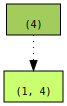

In [29]:
from torchviz import make_dot

make_dot(input_texts[0], params=dict(model.named_parameters()), show_attrs=True, show_saved=True)

In [31]:
test_target_texts

['kanlaya chanmun',
 'kan loetsukthawi',
 'kraison munphueng',
 'kanokthip laohawat',
 'krapukluk',
 'kenika khuroda',
 'kamon rueangchan',
 'kanthicha chaktri',
 'kat chueasila',
 'konwika sahatsachan',
 'kulap buain',
 'kannika khrueafan',
 'kopkun ingkhuthanon',
 'kusuma phonthuk',
 'krit kitikoset',
 'kitti trongnetpanya',
 'klinthip phimngoen',
 'kaenkluai',
 'kritin tilakanon',
 'krachang chonpru',
 'kunchong chuthanit',
 'kamphaengphasi',
 'krittiya sutthakun',
 'kraising chinphrawo',
 'keson kapanya',
 'kon rangrak',
 'kiatphanom somphila',
 'kulap charoenphun',
 'kanlaya thepdaeng',
 'kiatkan',
 'kanokphon rangsom',
 'kulitra arunsaeng',
 'ketri dipradap',
 'krit suchittharakun',
 'kittikhun tangsiwong',
 'kantaphon uamsaat',
 'kowit malaisirirat',
 'kamonwan miphan',
 'kawiphot karaket',
 'kritsana chankaeo',
 'kaeowandi phaphum',
 'krithep klinchan',
 'kanok bunyarattawet',
 'kaeota phensichon',
 'kulap motnak',
 'klairung bunchok',
 'kanlaya koetprawat',
 'kittichot thapwon

In [32]:
from jiwer import cer

In [33]:
cer(test_target_texts,pred)

0.35581121788271103

In [34]:
pred

['2anlaya chanmuna',
 'gan loetsu',
 '<pad>',
 '8ano',
 '8rapu',
 '8eni',
 '8amon rueangchana',
 '2anthicha cha',
 '<pad>',
 '8onwi',
 '3ulap buain',
 '8anni',
 '8op',
 '8usuma phonthu',
 '8rit ',
 '8itti trongnetpanyaa',
 '8linthip phimngoena',
 'haen',
 '8ritin tila',
 '8rachang chonpru',
 '3unchong chuthanita',
 '8amphaengphasiiii',
 '8rittiya suttha',
 'hraising chinphrawo',
 '8eson ',
 '8on rangra',
 '8iatphanom somphilaa',
 '2ulap charoenphuna',
 '8anlaya thepdaengang',
 '8iat',
 '8ano',
 '2ulitra arunsaengang',
 '8etri dipradapap',
 '8rit suchitthara',
 '8itti',
 '8antaphon uamsaata',
 '8owit malaisirirata',
 '8amonwan miphana',
 '8awiphot ',
 '8ritsana chan',
 '<pad>',
 '9rithep ',
 '8ano',
 '<pad>',
 '8ulap motna',
 'hlairung buncho',
 '2anlaya ',
 '8ittichot thapwonga',
 '8anphaetsiangng',
 '8abuea',
 '8riangsa',
 'hesi trangansiii',
 '8amonwan ',
 '8lairung daenghirana',
 '2ep amphaiapai',
 '8ano',
 '8asem ',
 'gan',
 '8anlaya',
 '8anni',
 'het',
 'hetthip supphawanita',
 '8

In [35]:
with open('72ep-pred.txt','w',encoding='utf-8') as f:
    f.write('\n'.join(pred))

In [36]:
with open('ground_truth.txt','w',encoding='utf-8') as f:
    f.write('\n'.join(test_target_texts))